# Milestone 3 - Regression Simulation 

## Author - Ana Javed



## Instructions

Using the California dairy production dataset, perform time series analysis on the data for one of Cottage Cheese Production, Milk Production, or Ice Cream Production (your choice) to answer the following questions:

1. Is this time series stationary?
2. Is there a significant seasonal component?
3. For the residual from the STL decomposition of the time series, what is the order of the ARMA(p,q) process that best fits?

Then forecast production for 12 months and report both numeric values and plot the confidence intervals.

1. Are the confidence intervals reasonably small compared to the forecast means?
2. How do the confidence intervals behave as time moves to the future?


### Note
Please clearly outline the results with markdown text. Be sure your discussion includes narrative for your figures and tables so it is clear to the reader the importance of each bit of evidence.

In [1]:
# Load necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as splt
import statsmodels.tsa.seasonal as sts
import statsmodels.tsa.arima_process as arima
import numpy as np
from statsmodels.tsa.stattools import adfuller
import sklearn.linear_model as lm

import pmdarima as pm
from pmdarima.arima import auto_arima

%matplotlib inline

In [2]:
## Data File URL 
fileName = "https://library.startlearninglabs.uw.edu/DATASCI410/Datasets/CADairyProduction.csv"

In [3]:
## Reading in the CSV filt into pandas data frame 
dairy_df = pd.read_csv(fileName)

## Top and Bottom 15 Rows 
# print(dairy_df.head(10))
# print(dairy_df.head(10))

In [4]:
## Exploratory Data Analysis 
print(dairy_df.columns) ## Printing Columns 
print(dairy_df.shape) ## Printing Data Dimensions 
print(dairy_df.dtypes) ## Printing Column Types 

Index(['Year', 'Month', 'Cotagecheese.Prod', 'Icecream.Prod', 'Milk.Prod',
       'N.CA.Fat.Price', 'Month.Count', 'monthNumSqred', 'monthNumCubed'],
      dtype='object')
(228, 9)
Year                   int64
Month                 object
Cotagecheese.Prod    float64
Icecream.Prod        float64
Milk.Prod            float64
N.CA.Fat.Price       float64
Month.Count            int64
monthNumSqred          int64
monthNumCubed          int64
dtype: object


In [5]:
## Converting Month and Year Column to Datetime Date Column in the Data Frame 
from datetime import datetime
dairy_df.loc[:, "Date"] = pd.to_datetime(dairy_df.loc[:, "Year"].astype(str) + '-' + dairy_df.loc[:, "Month"])

print(dairy_df.dtypes) ## Printing Column Types 


Year                          int64
Month                        object
Cotagecheese.Prod           float64
Icecream.Prod               float64
Milk.Prod                   float64
N.CA.Fat.Price              float64
Month.Count                   int64
monthNumSqred                 int64
monthNumCubed                 int64
Date                 datetime64[ns]
dtype: object


#### Focusing specifically on the Milk Production category in the Dairy Production Dataset 

In [6]:
## Only examining the Milk Production and Date columns 
milk_df = dairy_df.loc[:, ["Date","Milk.Prod"]]
milk_df = milk_df.set_index("Date")

print(milk_df)

            Milk.Prod
Date                 
1995-01-01      2.112
1995-02-01      1.932
1995-03-01      2.162
1995-04-01      2.130
1995-05-01      2.227
...               ...
2013-08-01      3.400
2013-09-01      3.197
2013-10-01      3.338
2013-11-01      3.275
2013-12-01      3.473

[228 rows x 1 columns]


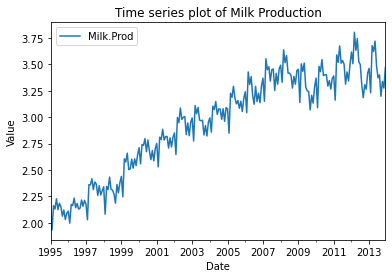

In [7]:
## Plotting the Time Series Plot of Milk Production 
def plot_ts(ts, lab = ''):
    ts.plot()
    plt.title('Time series plot of ' + lab)
    plt.ylabel('Value')
    plt.xlabel('Date')

plot_ts(milk_df, 'Milk Production')

### Time Series Plot Analysis 
The time series plot has an upward trend, abd the amplitude of the seasonal variation does grow with time. However we see that it briefly dips around 2009 and slightly again at 2012.

Seeing this upward trend suggests that we should use a multiplicative decomposition model. 

Index(['Milk.Prod', 'milk_prod_log'], dtype='object')

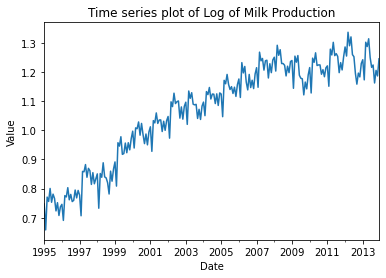

In [8]:
# Taking the Log of Milk Production 
milk_df['milk_prod_log'] = np.log(milk_df["Milk.Prod"])

# Plotting the new Log Milk Production Column 
plot_ts(milk_df.milk_prod_log, 'Log of Milk Production')
milk_df.columns

### 1.) Is this time series stationary?
No, this time series is not stationary since the variance does appear to vary over time. 

### 2.) Is there a significant seasonal component to this time series?
There does appear to be a significant seasonal component in the plot above. I will explore this in detail when conducting the decomposition of the time series below, but there appears to be a repeated rhythm across the years. 



### 3.) Perform STL decomposition of the time series. Should this decomposition be performed with the additive or multiplicative (log of values) model? Are the residuals stationary?

After taking the log of milk production values (above plot), I notice that the plot still has a significant trend, there are more noticeable seasonsal components, and the magnitude continues to increase and slightly decreases towards the end.

Seeing this upward trend suggests that we should use a multiplicative decomposition model.

I will explore whether the residuals are stationary below when conducting the decomposition of the time series. 

#### SLT Decomposition of the Log Milk Production 

In [11]:
## Defining Decomposition Function 
def decomp_ts(ts, freq = 'M', model = 'additive'):
    res = sts.seasonal_decompose(ts, model = model)
    res.plot()
    return(pd.DataFrame({'resid': res.resid, 
                         'trend': res.trend, 
                         'seasonal': res.seasonal},
                       index = ts.index) )


               resid     trend  seasonal
Date                                    
1995-01-01       NaN       NaN  0.009169
1995-02-01       NaN       NaN -0.063646
1995-03-01       NaN       NaN  0.046570
1995-04-01       NaN       NaN  0.026694
1995-05-01       NaN       NaN  0.053586
1995-06-01       NaN       NaN  0.004263
1995-07-01  0.026259  0.746283  0.008616
1995-08-01  0.016510  0.747581  0.002307
1995-09-01  0.014267  0.749151 -0.039741
1995-10-01  0.008047  0.750003 -0.006162
1995-11-01 -0.003504  0.750755 -0.039215
1995-12-01 -0.011135  0.751219 -0.002441
               resid     trend  seasonal
Date                                    
2013-01-01  0.002499  1.230179  0.009169
2013-02-01  0.006582  1.229856 -0.063646
2013-03-01  0.024035  1.231219  0.046570
2013-04-01  0.028554  1.231778  0.026694
2013-05-01  0.027831  1.232307  0.053586
2013-06-01  0.012240  1.233112  0.004263
2013-07-01       NaN       NaN  0.008616
2013-08-01       NaN       NaN  0.002307
2013-09-01      

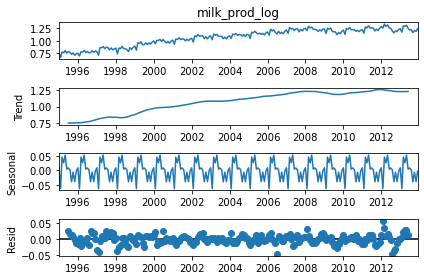

In [12]:
## Applying the Decomposition function to the Log Milk Production Data 
milk_decomp = decomp_ts(milk_df.milk_prod_log)

## Printing Top and Bottom 12 Rows of the Residual Data Frame
print(milk_decomp.head(12)) 
print(milk_decomp.tail(12))

The decomposition results look appropriate. There are little to no seasonal changes across time, so the removal of the trend component appears to be sufficient. Also the trend plot is correctly linear. The remainders may suggest that the data may not be stationary since there are larger values shown as time increases. 

It is also important to note that the residual and trend columns have NaN values in the first and last 6 rows of the data frame since it's a monthly time series. We will separate these out when applying the Dicky Fuller test. 

In [13]:
## Conducting the Dicky Fuller Test

# Declaring the Function 
def DF_Test(ts):
    stationary = adfuller(ts)
    ## Print the results
    print('D-F statistic = ' + str(stationary[0]))
    print('p-value = ' + str(stationary[1]))
    print('number of lags used = ' + str(stationary[2]))
    print('Critical value at 5% confidence = ' + str(stationary[4]['5%']))
    print('Critical value at 10% confidence = ' + str(stationary[4]['10%']))
    
## Applying the Test to the decomposition residuals 
DF_Test(milk_decomp.resid[6:-6])    

D-F statistic = -8.280935682685262
p-value = 4.521792223864514e-13
number of lags used = 7
Critical value at 5% confidence = -2.875537986778846
Critical value at 10% confidence = -2.574231080806213


Given the large DF statistic and that the p-value is very small, we can reject the null hypothesis that the residual is not stationary. 

### ACF and PACF Plots for remainder series: 

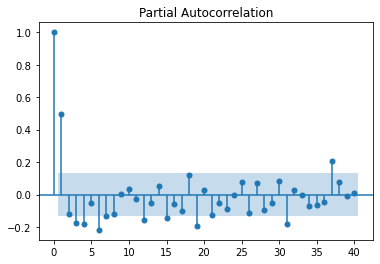

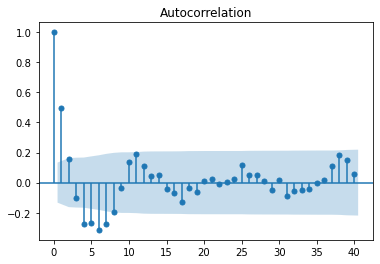

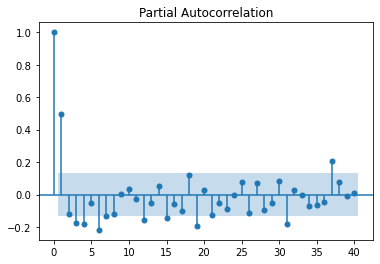

In [14]:
splt.plot_acf(milk_decomp.resid[6:-6], lags = 40)
splt.plot_pacf(milk_decomp.resid[6:-6], lags = 40)

### 4.) Use the auto_arima function from the pmdarima package to find a best model fit, excluding the last 12 months of observations from the training data, and setting d=1 and D=1 and limit p, q, P and Q to 3 with starting values of 1. Which model coefficients are statistically significant?


In [15]:
## Splitting Test and Training Data 
train = milk_df[:-12]
test = milk_df[-12:]

## Removing the Non-Log column 
train = train.drop("Milk.Prod", axis = 1)
test = test.drop("Milk.Prod", axis = 1)

# print(train) # 1995 to 2012 Data Values
# print(test) # 2013 Year Data Values

In [16]:
import pmdarima as pm
from pmdarima.arima import auto_arima

## Applying the Auto_arima function
stepwise_fit = auto_arima(milk_df.loc[:,"milk_prod_log"], start_p=1, start_q=1,
                             max_p=3, max_q=3, m=12,
                             start_P=0, seasonal=True,
                             d=1, D=1, trace=True,
                             error_action='ignore',  # ignoring if an order does not work
                             suppress_warnings=True,  # removing convergence warnings
                             stepwise=True)  # set to stepwise

## Printing Summary & Best AIC value
print(stepwise_fit.summary())

print("Best AIC Value: ", stepwise_fit.aic())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=-1148.055, Time=0.89 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-1031.424, Time=0.07 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-1096.821, Time=0.39 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-1147.777, Time=0.54 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=-1036.231, Time=0.07 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=-1147.360, Time=1.97 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=-1148.026, Time=4.15 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=-1096.394, Time=0.26 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=-1144.822, Time=9.13 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=-1147.283, Time=1.34 sec
 ARIMA(2,1,1)(0,1,1)[12]             : AIC=-1144.901, Time=0.86 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=-1144.757, Time=1.22 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=-1145.671, Time=0.52 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=-1146.660, Time=1.87 sec
 ARIM

#### Summary Review

Using the AIC value, we see that the best model suggested by the Auto_arima function is the ARIMA(1,1,1)(0,1,1)[12] which has an AIC value of -1147.122. 

All of the model coeffients are statistically significant, since the p-values are less than 0.05 and the confidence intervals do not contain zero (aside from sigma2).


In [17]:
## Fitting the Model with the Training Dataset 
stepwise_fit.fit(train)

## Using the Model to predict the values of the Test Dataset
predictions, CI = stepwise_fit.predict(n_periods=test.shape[0], return_conf_int = True)

# print(predictions)
# print(test)

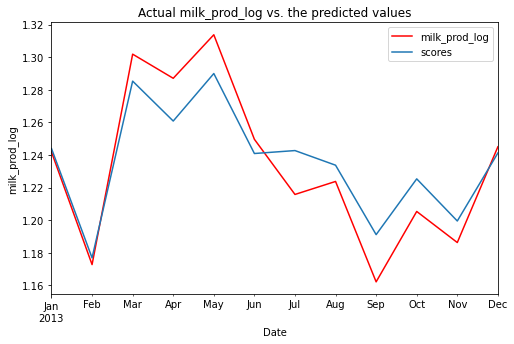

In [18]:
def plot_mod_fit(df, col):
    import matplotlib.pyplot as plt
    fig = plt.figure(figsize=(8, 5)) # set plot area
    ax = fig.gca() # define axis  
    df.loc[:, col].plot(color = 'r', ax = ax)
    df.loc[:, 'scores'].plot(ax = ax) 
    ax.set_title('Actual ' + col + ' vs. the predicted values') # Give the plot a main title
    ax.set_xlabel('Date') # Set text for the x axis
    ax.set_ylabel(col)# Set text for y axis
    ax.legend()
    
## Adding the Scores Column 
predictions = pd.DataFrame(predictions, index = test.index,
                               columns=['scores'])

predictions = pd.concat([test, predictions],axis=1)

## Adding a Residual Column 
predictions.loc[:, "residual"] = predictions.loc[:, "scores"] - predictions.loc[:, "milk_prod_log"]


## Plotting Prediction vs Actual Values 
plot_mod_fit(predictions, 'milk_prod_log')

### 1. Are the predictions close to the actual observations?

These predictions are close to the actual observations. The two lines in the plot above do not overlap on some parts (March to November, for example) however the difference between the values are small and are about 0.02. The best way to check how close the actual observations are to the predictions is relying on the RMSE.

### 2. Are the residuals approximately Normally distributed?



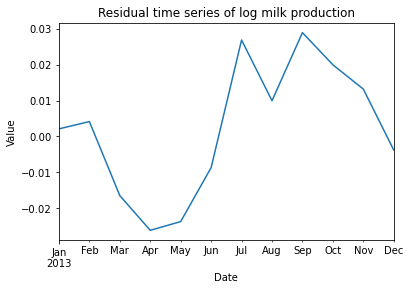

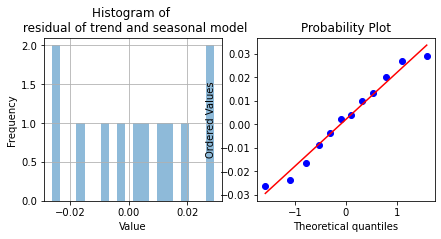

In [19]:
def dist_ts(ts, lab = '', bins = 20):
    import scipy.stats as ss
    ## Setup a figure with two subplots side by side
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3))
    ## Plot the histogram with labels
    ts.hist(ax = ax1, bins = bins, alpha = 0.5)
    ax1.set_xlabel('Value')
    ax1.set_ylabel('Frequency')
    ax1.set_title('Histogram of ' + lab)
    ## Plot the q-q plot on the other axes
    ss.probplot(ts, plot = ax2)
    
def plot_ts(ts, title):
    ts.plot()
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Value')
    
    
    
plot_ts(predictions.loc[:, 'residual'],  
        title = 'Residual time series of log milk production' )

dist_ts(predictions.loc[:, 'residual'], 
        '\n residual of trend and seasonal model')

The time series of the residual doesn't clearly show any periodic behaivor. The histogram of the residual data appears to be more bimodal than normally distributed, however the probability plot does appear to fall closely to the red line. 

### 3. What is the RMSE? Is this value small relative to the forecasted values?

In [20]:
def RMSE(ts, score):
    from math import sqrt
    return sqrt(np.std(ts - score))

RMSE(predictions.loc[:, "milk_prod_log"], predictions.loc[:, "scores"])

0.13353281807744868

A root mean square error (RMSE) of the fit of the model for the last 12 months in the data of milk production is 0.133. This is not too high considering the relative values of the forecast range from 1.16 to 1.32.

In [21]:
print("Confidence Intervals for the Predictions in 2013: ")
print(CI)

print("\n")

print("Mean for the Forecast/Predictions: ")
print(np.mean(predictions))

Confidence Intervals for the Predictions in 2013: 
[[1.21271233 1.27517825]
 [1.1360566  1.21780393]
 [1.23772962 1.33285653]
 [1.20778149 1.31385547]
 [1.23209872 1.34780163]
 [1.17866418 1.30314221]
 [1.17639403 1.30902417]
 [1.16358985 1.30388187]
 [1.11739273 1.26494241]
 [1.14812329 1.30258724]
 [1.11898633 1.280067  ]
 [1.15749376 1.32492959]]


Mean for the Forecast/Predictions: 
milk_prod_log    1.233777
scores           1.235962
residual         0.002185
dtype: float64


In [22]:
## Identifying how the Confidence Interval Range change as Time Increases  
## Taking the difference of the upper CI value minus the lower CI value 

for each in CI:
    print(each[1] - each[0])

0.06246591438252391
0.08174732668461981
0.09512690792609257
0.10607397693544796
0.11570291290188539
0.12447803334099206
0.13263014375578974
0.14029202356469606
0.14754967346532677
0.15446394980838907
0.1610806677374228
0.1674358262998612


### 4. Are the confidence intervals reasonably small compared to the forecast means?
I do believe that the confidence interval ranges are small compared to the forecast mean (1.235). The actual mean for the subset is 1.234, which is very close to each other. 

### 5. How do the confidence intervals behave as time moves to the future?
I took the difference of each of the confidence intervals, and as time moves in the future, the range of the confidence range increases. It initially had a range of 0.062 in January, and as time continues, the range increases to 0.167. 